# Collocate ERA5 and back trajectories: 

Produces ***FigureS5***

Possible mistake in the code when collocating the data sets 


"""year_to_df_dict_next = dict({str(year+1):df_next[df_next['DateTime'].dt.year == year+1], 
                              str(year+2):df_next[df_next['DateTime'].dt.year == year+2]})
        df_year = pd.concat([year_to_df_dict[str(year)], year_to_df_dict_next[str(year)]])"""

In [1]:
import glob
import pandas as pd
import datetime
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
from datetime import timedelta
import dask.dataframe as dd

import os
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr

from mpl_toolkits.basemap import Basemap, addcyclic, cm

import sys

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\HYSPLIT_plotting')
import HYSPLIT_plotting as HYplot

import os, psutil
process = psutil.Process()
print(process.memory_info().rss/1024.0**3)  # in bytes 

print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
print(psutil.virtual_memory())

0.16898345947265625
173.0390625
svmem(total=34131161088, available=20674084864, percent=39.4, used=13457076224, free=20674084864)


In [2]:
#find the size of loaded variables
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       Basemap:  1.0 KiB
               NamespaceMagics:  896.0 B
                            _i:  775.0 B
                           _i1:  775.0 B
                           _i2:  611.0 B
                     timedelta:  416.0 B
                           _oh:  232.0 B
                           Out:  232.0 B
                   get_ipython:  136.0 B
                    _getsizeof:  136.0 B


In [3]:
def load_year_of_datetime_trajs(year, inpath="E:\\Data\\HYSPLIT\\processed\\", folder='abs', obs_col='obs',
                                select_for_mixed_layer=False, select_for_above_mixed_layer=False,
                                usecols=['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 
                                        'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude'],
                                data_format='.dat'):
    #use the current year
    dict_dtype = dict(zip(['Traj_num', 'grid_lon', 'grid_lat', obs_col,'time_step'], 
                          [np.int8, np.int16, np.int8, np.float16, np.float16]))
    
    df = HYplot.concat_years(inpath, folder=folder, years=np.arange(year, year+1, 1),
                            index_col=False, parse_dates=True, dict_dtype=dict_dtype,
                            usecols=usecols,
                            select_for_mixed_layer=select_for_mixed_layer, 
                            select_for_above_mixed_layer=select_for_above_mixed_layer, data_format=data_format)
    
    df['arrival_time'] = pd.to_datetime(df['arrival_time']) #
    df = df.reset_index()
    year_to_df_dict = dict({str(year-1):df[df['DateTime'].dt.year == year-1], 
                          str(year):df[df['DateTime'].dt.year == year]})
    #add the backwards part of the next year, if possible
    try:
        print("added the next year:")
        df_next= HYplot.concat_years(inpath, folder=folder, years=np.arange(year+1, year+2, 1),
                                      index_col=False, parse_dates=True, dict_dtype=dict_dtype,
                                      usecols=usecols,
                                     select_for_mixed_layer=select_for_mixed_layer, 
                                     select_for_above_mixed_layer=select_for_above_mixed_layer,
                                     data_format=data_format)
        df_next['arrival_time'] = pd.to_datetime(df_next['arrival_time']) #
        df_next = df_next.reset_index()
        year_to_df_dict_next = dict({str(year+1):df_next[df_next['DateTime'].dt.year == year+1], 
                              str(year+2):df_next[df_next['DateTime'].dt.year == year+2]})
        df_year = pd.concat([year_to_df_dict[str(year)], year_to_df_dict_next[str(year)]])
    except:
        df_year = year_to_df_dict[str(year)]
    return df_year

In [4]:
def append_var_to_df(df_trajs, ds_ERA5, var, var_name):
    df_trajs = df_trajs.copy()
    df_trajs.loc[:, var_name] = ds_ERA5[var].sel(latitude=xr.DataArray(df_trajs['latitude']),
                                           longitude=xr.DataArray(df_trajs['longitude']),
                                           time=xr.DataArray(df_trajs['DateTime']),
                                           method='nearest')
    df_trajs[var_name] = df_trajs[var_name].astype(float)
    df_trajs[var_name] = df_trajs[var_name]*10**3
    return df_trajs

In [5]:
def append_var_columnwise(df_trajs, var_list):
    df_trajs = df_trajs.copy()
    var_list=[str(x)+'_era5' for x in var_list] #new names   
    df_trajs.loc[:, var_list] = df_trajs[['latitude', 'longitude', 'DateTime']].apply(lambda x: find_variables_lat_lon(*x), axis=1)
    return df_trajs

In [31]:
savepath = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\df_trajs_ERA5'
ERA5_path = r'D:\\ERA5\\'
HYSPLIT_path = "F:\\HYSPLIT\\processed\\"

savepath_plot = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

# Collocate the data: 

In [56]:
years = [2010] 

nslice = None
var_name='tp_era5'
var = 'tp'
data_format = '.pickle'

for year in years:
    months=np.arange(2, 3, 1) #
        
    print("year: "+str(year))
    try:
        del df
    except:
        print("no df")
        pass
    
    df = load_year_of_datetime_trajs(year, HYSPLIT_path, obs_col='obs',
                                    select_for_mixed_layer=False, select_for_above_mixed_layer=False,
                                    data_format=data_format)    
    print("months: "+str(months))
    print("var name: "+str(var_name))
    for month in months:           
        print("month: "+str(month))        
        df_month = df[df['DateTime'].dt.month == month] #take endpoints of that month
        print("Number of endpoints to collocate: "+str(len(df_month)))   
        if len(df_month) > 0:
            month = "{:02d}".format(month) #make 0X
            print('open: \\ERA5\\'+str(year)+'\\ERA5_'+str(year)+'_'+str(month)+'.nc') 
            try:
                del ds_ERA5
            except:
                print("no ds_ERA5")
                pass
            ds_ERA5 = xr.open_dataset(str(ERA5_path)+str(year)+'\\ERA5_'+str(year)+'_'+str(month)+'.nc') 
            #drop_variables
            
            ERA5_year_check = int(ds_ERA5.time.dt.year.mean().values)    
            print(ERA5_year_check)
            ERA5_month_check = int(ds_ERA5.time.dt.month.mean().values)    
            print(ERA5_month_check)  
            
            if (year == ERA5_year_check) & (int(month) == ERA5_month_check):
                print("yes")                
                if nslice is not None:
                    df_month = df_month.iloc[:nslice,:] 
                
                df_month = append_var_to_df(df_month, ds_ERA5, var, var_name)
                
                try:
                    df_month.to_csv(savepath+'//'+str(year)+'_'+str(month)+'_tp_all.dat', index=False)
                    print("saved as: "+str(savepath)+'//'+str(year)+'_'+str(month)+'_tp_all.dat')
                except FileNotFoundError:
                    os.makedirs(savepath+'//', exist_ok=True)
                    df_month.to_csv(savepath+'//'+str(year)+'_'+str(month)+'_tp_all.dat') 

year: 2010
no df
F:\HYSPLIT\processed\abs\dfs\
F:\HYSPLIT\processed\abs\dfs\\2010*.pickle
no years provided, just a year
['F:\\HYSPLIT\\processed\\abs\\dfs\\2010.pickle']
F:\HYSPLIT\processed\abs\dfs\2010.pickle
Length before: 47810196
Length after: 40115412
['Traj_num', 'grid_lon', 'grid_lat', 'obs', 'time_step']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40115412 entries, 2010-01-01 00:00:00 to 2010-03-07 01:00:00
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Traj_num      int8   
 1   time_step     float16
 2   grid_lat      int8   
 3   grid_lon      int16  
 4   obs           float16
 5   arrival_time  object 
 6   RAINFALL      float64
 7   latitude      float64
 8   longitude     float64
dtypes: float16(2), float64(3), int16(1), int8(2), object(1)
memory usage: 4.3 GB
size of df: 40115412
added the next year:
F:\HYSPLIT\processed\abs\dfs\
F:\HYSPLIT\processed\abs\dfs\\2011*.pickle
no years provided, just a year
['F:\\HYSPLIT

In [46]:
year = 2009 
month = '01'
df_month = pd.read_csv(savepath+'//'+str(year)+'_'+str(month)+'_tp_all.dat')

In [57]:
df_month.head(2)

,DateTime,Traj_num,time_step,grid_lat,grid_lon,obs,arrival_time,RAINFALL,latitude,longitude,tp_era5
3318570,2010-02-01 11:00:00,1,0.0,90,198,0.140015,2010-02-01 11:00:00,0.0,78.906,11.888,0.000941
3318571,2010-02-01 11:00:00,2,0.0,90,198,0.140015,2010-02-01 11:00:00,0.0,78.906,11.888,0.000941


In [78]:
def get_average_back_traj_from_ensemble(df):
    df_tp_era5_sum = df.groupby('arrival_time').agg({'tp_era5': np.sum})
    df_RAINFALL_sum = df.groupby('arrival_time').agg({'RAINFALL': np.sum})

    df_Traj_num_nunique = df.groupby('arrival_time').agg({"Traj_num": lambda x: x.nunique()})
    df_timestep_count = df.groupby('arrival_time').agg({'time_step': 'count'})

    df_timesteps_ensemble =  df_timestep_count['time_step'].div(df_Traj_num_nunique['Traj_num'])
    df_timesteps_ensemble = (df_timesteps_ensemble/241).to_frame(name='fraction_241')

    df_tp_era_per_bj = df_tp_era5_sum['tp_era5'].div(df_Traj_num_nunique['Traj_num']).to_frame(name='tp_era5')
    df_RAINFALL_per_bj = df_RAINFALL_sum['RAINFALL'].div(df_Traj_num_nunique['Traj_num']).to_frame(name='RAINFALL')

    df_ave_bj = pd.merge(df_timesteps_ensemble, df_tp_era_per_bj, left_index=True, right_index=True)
    df_ave_bj = pd.merge(df_ave_bj, df_RAINFALL_per_bj, left_index=True, right_index=True)

    df_ave_bj = df_ave_bj[df_ave_bj['fraction_241'] == 1]

    df_ave_bj = df_ave_bj[(df_ave_bj['fraction_241'] >= 1) & (df_ave_bj['fraction_241'] <= 1.15)]

    df_ave_bj.index = pd.to_datetime(df_ave_bj.index)
    return df_ave_bj

In [59]:
df_ave_bj = get_average_back_traj_from_ensemble(df_month)

In [76]:
df_ave_bj.head(2)

,fraction_241,tp_era5,RAINFALL
arrival_time,,,
2010-02-11 00:00:00,1.0,14.273607,14.333333
2010-02-11 01:00:00,1.0,13.271428,13.962963


In [66]:
df_era5_GDAS = HYplot.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat


In [70]:
df_era5_GDAS[df_era5_GDAS.index == '2010-02-11 01:00:00']

,fraction_241,tp_era5,RAINFALL
arrival_time,,,
2010-02-11 01:00:00,1.0,13.268519,13.962963


# Read in proccessed months 

Append preprocessed data: 

append the collocated months and save the year

In [48]:
def read_in_months(year, months, path=savepath, 
                   dict_dtypes=dict_dtypes, parse_dates=['DateTime'],
                   usecols=['DateTime', 'time_step', 'Traj_num', 'RAINFALL', 'MIXDEPTH', 'RELHUMID',
                            'H2OMIXRA','arrival_time', 'tp_era5', 'altitude']):
    DFs = []
    for month in months:
        print("month: "+str(month))
    #try:
        month = "{:02d}".format(month) #make 0X
        print(str(path)+'\\'+str(year)+'_'+str(month)+'_tp_all.dat')
        df_month = pd.read_csv(str(path)+'\\'+str(year)+'_'+str(month)+'_tp_all.dat',
                               dtype=dict_dtypes, parse_dates=parse_dates,
                               usecols=usecols)
        print(df_month.head(2))
        DFs.append(df_month)
    #except:
    #    pass
    df = pd.concat(DFs)
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    return df

In [51]:
dict_dtypes = {'time_step': np.dtype('int16'), #-32,768 to 32,767 
             'Traj_num': np.dtype('int8'),  #-128 to 127
             'RAINFALL': np.dtype('float16'),
             'MIXDEPTH': np.dtype('float16'),
             'altitude': np.dtype('float16'),
             'RELHUMID': np.dtype('float16'),
             'H2OMIXRA': np.dtype('float16'),
             'tp_era5': np.dtype('float16'),
              } 

cols = ['DateTime', 'time_step', 'Traj_num', 'RAINFALL',
        'arrival_time', 'tp_era5'] 

for year in np.arange(2009, 2010, 1): #2002 - 2024
    print(year)
    DFs = []
    for year in np.arange(year, year+1, 1): 
        print("year: "+str(year))
        df = read_in_months(year, months=np.arange(1, 2, 1), usecols=cols, 
                            dict_dtypes=dict_dtypes) #1 - 13
        df = df[cols]
        DFs.append(df)
        if df is not None:
            print("delete df")
            del df          
    df_years = pd.concat(DFs)
    df_years.to_pickle(path+'\\'+str(year)+'.pickle')

2009
year: 2009
month: 1
C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\df_trajs_ERA5\2009_01_tp_all.dat
    DateTime  Traj_num  time_step         arrival_time  RAINFALL   tp_era5
0 2009-01-03         1          0  2009-01-03 00:00:00       0.0  0.000594
1 2009-01-03         2          0  2009-01-03 00:00:00       0.0  0.000594
delete df


# Append years: 

## append years into one mega file and save: 

In [ ]:
path = r'E:\df_trajs_ERA5\years'

select_for_mixed_layer == True

DFs = []

cols = ['time_step', 'Traj_num', 'RAINFALL', 'MIXDEPTH', 'altitude', 
        'RELHUMID', 'H2OMIXRA', 'arrival_time', 'tp_era5']

select_cols = ['time_step', 'Traj_num', 'RAINFALL', 'arrival_time', 'tp_era5']

for year in np.arange(2002, 2024, 1):
    print(year)
    df = pd.read_pickle(r'E:\df_trajs_ERA5\years'+'\\'+str(year)+'.pickle')
    
    if select_for_mixed_layer == True:
        df = df[df['altitude'] <= df['MIXDEPTH']]
        
    df = df.reset_index()
    df = df.astype(dict_dtypes)
    df = df[select_cols]
    df = df.set_index('arrival_time')

    DFs.append(df)
    if df is not None:
        print("delete df")
        del df        
    print(process.memory_info().rss/1024.0**3) 
    print(psutil.virtual_memory())
    
df_allyears = pd.concat(DFs)
df_allyears = df_allyears.sort_values(['arrival_time'])
if select_for_mixed_layer == True:
    df_allyears.to_pickle(path+'\\all_years_ML.pickle')
if select_for_mixed_layer == False:
    df_allyears.to_pickle(path+'\\all_years.pickle')

## a different method for appending the data files: 

In [ ]:
path = r'E:\df_trajs_ERA5\years'

select_cols = ['time_step', 'Traj_num', 'RAINFALL', 'arrival_time', 'tp_era5']
df_allyears=pd.DataFrame()
for year in np.arange(2002, 2024, 1):
    
    print(year)
    df = pd.read_pickle(r'E:\df_trajs_ERA5\years'+'\\'+str(year)+'.pickle')
    df = df.reset_index()
    df = df.astype(dict_dtypes)
    df = df[select_cols]
    df = df.set_index('arrival_time')    

    df_allyears=df_allyears.append(df,ignore_index=False)
    
    if df is not None:
        print("delete df")
        del df 
        
    df_allyears.to_pickle(path+'\\all_years.pickle')
    print(process.memory_info().rss/1024.0**3) 
    print(psutil.virtual_memory())

In [2]:
df_allyears = pd.read_pickle(r'E:\df_trajs_ERA5\years\all_years.pickle')
df_allyears.info(memory_usage="deep")

# load pickel: 

Load the full data set, year by year - groupby arrival time 

## groubpy year by year: 

In [ ]:
df_allyears = pd.read_pickle(r'E:\df_trajs_ERA5\years\all_years.pickle')
df_allyears = df_allyears.drop(['Traj_num', 'RAINFALL', 'tp_era5'], axis=1)

In [4]:
df_allyears.head(2)

,time_step
arrival_time,
2002-03-08 14:00:00,73
2002-03-08 14:00:00,73


### ERA5 precipitation: 

In [10]:
path = r'E:\df_trajs_ERA5\years'
var = 'tp_era5'

for year in np.arange(2023, 2024):
    print(year)
    if df_groupby_result is not None:
        del df_groupby_result
        print("delete")
    df_groupby_result = df_allyears[df_allyears.index.year == year].groupby('arrival_time').agg({'tp_era5': np.sum})
    print("saving:")
    df_groupby_result.to_pickle(path+'\\'+str(var)+'_groupbyarrival_'+str(year)+'.pickle')

2023
delete
saving:


In [7]:
df_groupby_result = pd.read_pickle(path+'\\'+str(var)+'_groupbyarrival_'+str(year)+'.pickle')

In [9]:
df_groupby_result.head(2)

,tp_era5
arrival_time,
2022-01-01 00:00:00,0.000000
2022-01-01 01:00:00,0.007797


### RAINFALL 

groupby every year: 

In [ ]:
path = r'E:\df_trajs_ERA5\years'
var = 'RAINFALL'
savepath = path+'\\'+var
if not os.path.exists(savepath):
    os.makedirs(savepath)

for year in np.arange(2002, 2024):
    print(year)
    if df_groupby_result is not None:
        del df_groupby_result
        print("delete")
    df_groupby_result = df_allyears[df_allyears.index.year == year].groupby('arrival_time').agg({str(var): np.sum})
    print("saving:")
    df_groupby_result.to_pickle(savepath+'\\'+str(var)+'_groupbyarrival_'+str(year)+'.pickle')

### Traj_num 

number of unique values (i.e. 27 if full ensemble): 

In [ ]:
path = r'E:\df_trajs_ERA5\years'
var = 'Traj_num'
savepath = path+'\\'+var
if not os.path.exists(savepath):
    os.makedirs(savepath)

for year in np.arange(2002, 2024):
    print(year)
    try:
        if df_groupby_result is not None:
            del df_groupby_result
            print("delete")
    except:
        pass
    df_groupby_result = df_allyears[df_allyears.index.year == year].groupby('arrival_time').agg({"Traj_num": lambda x: x.nunique()})
    print("saving:")
    df_groupby_result.to_pickle(savepath+'\\'+str(var)+'_groupbyarrival_'+str(year)+'.pickle')

### Time step: 

In [ ]:
path = r'F:\df_trajs_ERA5\years'
var = 'time_step'
savepath = path+'\\'+var
if not os.path.exists(savepath):
    os.makedirs(savepath)

for year in np.arange(2002, 2024):
    print(year)
    try:
        if df_groupby_result is not None:
            del df_groupby_result
            print("delete")
    except:
        pass
    df_groupby_result = df_allyears[df_allyears.index.year == year].groupby('arrival_time').agg({str(var): 'count')
    print("saving:")
    df_groupby_result.to_pickle(savepath+'\\'+str(var)+'_groupbyarrival_'+str(year)+'.pickle')

# Load groupbys together: 

In [77]:
select_cols = ['time_step', 'Traj_num', 'RAINFALL', 'arrival_time', 'tp_era5']
path = r'F:\df_trajs_ERA5\years'

In [80]:
def concat(var, path = r'E:\df_trajs_ERA5\years'):
    loadpath = path+'\\'+var
    DFs = []
    for year in np.arange(2002, 2024, 1):
        df = pd.read_pickle(loadpath+'\\'+str(var)+'_groupbyarrival_'+str(year)+'.pickle')
        DFs.append(df)
    df = pd.concat(DFs)
    print("concating")
    return df

In [81]:
df_timestep_count = concat('time_step', path = r'F:\df_trajs_ERA5\years')
df_RAINFALL_sum = concat('RAINFALL', path = r'F:\df_trajs_ERA5\years')
df_tp_era5_sum = concat('tp_era5', path = r'F:\df_trajs_ERA5\years')
df_Traj_num_nunique = concat('Traj_num', path = r'F:\df_trajs_ERA5\years')

concating
concating
concating
concating


In [82]:
df_timesteps_ensemble =  df_timestep_count['time_step'].div(df_Traj_num_nunique['Traj_num'])
df_timesteps_ensemble = (df_timesteps_ensemble/241).to_frame(name='fraction_241')

df_tp_era_per_bj = df_tp_era5_sum['tp_era5'].div(df_Traj_num_nunique['Traj_num']).to_frame(name='tp_era5')
df_RAINFALL_per_bj = df_RAINFALL_sum['RAINFALL'].div(df_Traj_num_nunique['Traj_num']).to_frame(name='RAINFALL')

df_ave_bj = pd.merge(df_timesteps_ensemble, df_tp_era_per_bj, left_index=True, right_index=True)
df_ave_bj = pd.merge(df_ave_bj, df_RAINFALL_per_bj, left_index=True, right_index=True)

df_ave_bj = df_ave_bj[df_ave_bj['fraction_241'] == 1]
df_ave_bj = df_ave_bj[(df_ave_bj['fraction_241'] >= 1) & (df_ave_bj['fraction_241'] <= 1.15)]

In [128]:
HYplot.save_df(df_ave_bj, path=r'C:\Users\DominicHeslinRees\Documents\Analysis\ERA5_rainfall',
              name='era5_GDAS_2002_2023')

Save as: C:\Users\DominicHeslinRees\Documents\Analysis\ERA5_rainfall\era5_GDAS_2002_2023_v2.dat


# Load and plot: 

In [75]:
def fancy(ax, fontsize=20):    
    # thickning the axes spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=0.5)    
    # mask top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def q25(x, percentile=0.25):
    return x.quantile(percentile)

def q75(x):
    return x.quantile(0.75) 

def monthly_accumulated_rainfall(df, var='RAINFALL'):
    df_arrival_time = df[['arrival_time', 'RAINFALL', 'tp_era5']].groupby('arrival_time').sum()/27 #lets change this 
    df_arrival_time.index = pd.to_datetime(df_arrival_time.index)
    df_arrival_time['arrival_time_month'] = df_arrival_time.index.month
    print(df_arrival_time['arrival_time_month'].unique())
    df_arrival_time_month = df_arrival_time.groupby('arrival_time_month')[var].agg(['mean', 'median', 'min', 'max', 'std', q25, q75])
    return df_arrival_time_month

def all_monthls_accumulated_rainfall(df, var='RAINFALL'):
    #df_arrival_time = df[['arrival_time', 'RAINFALL', 'tp_era5']].groupby('arrival_time').sum()
    df_arrival_time = df.copy()
    df_arrival_time.index = pd.to_datetime(df_arrival_time.index)
    df_arrival_time['month'] = df_arrival_time.index.month
    df_arrival_time['year'] = df_arrival_time.index.year
    df_arrival_time['arrival_time_year_month'] = (df_arrival_time.index.year-df_arrival_time.index.year[0])*12 + df_arrival_time.index.month
    print(df_arrival_time['arrival_time_year_month'].unique())
    df_arrival_time_month = df_arrival_time.groupby('arrival_time_year_month')[var].agg(['mean', 'median', 'min', 'max', 'std', q25, q75])
    return df_arrival_time_month

def add_datetime(df, startyear=2002):
    df['month'] = df.index%12
    df.loc[df.month == 0, 'month'] = 12
    df['month'] = df['month'].map("{:02}".format)
    df['year'] = (df.index/12).astype(int) + startyear
    df['day'] = "{:02d}".format(1)
    df['datetime'] = df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+df['day'].astype(str)
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
    return df
    
def quick_month_plot(df, display_label=False, fmt="o", color='k',
                    mfc='green', mec='k', ecolor='black', linecolour='k',
                    ms=3, label='', ax=None):
    quan_25 = df['q25'].values
    quan_75 = df['q75'].values
    index = df.index
    mean =  df['mean'].values
    median =  df['median'].values
    if display_label==True:
        error_label='Med + 25$^{\mathrm{th}}$ - 75$^{\mathrm{th}}$'
    if display_label==False:  
        error_label='_'        
    ax.plot(index, median, 'o', label=label, color=color, ls='-', alpha=.6)
    ax.plot(index, mean, 'x', label='', color=color, ls=':', ms=ms, alpha=.3) 
    fancy(ax)
    ax.set_ylabel('Median accumulated\n precipitation along [mm]', fontsize=20)
    ax.legend(frameon=False, fontsize=15, loc=1)
    return ax

In [ ]:
df_ave_bj = HYplot.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')

df_ave_bj[df_ave_bj.index == '2009-01-31']['RAINFALL']

In [39]:
df_RAINFALL = df_ave_bj.resample('M')['RAINFALL'].agg(['mean', 'median', 'min', 'max', 'std', q25, q75])
df_ERA5 = df_ave_bj.resample('M')['tp_era5'].agg(['mean', 'median', 'min', 'max', 'std', q25, q75])

# Figure S5: 

<ipython-input-38-212eea5f7158>:66: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, median, 'o-', label=label, color=color, ls='-', alpha=.6)
<ipython-input-38-212eea5f7158>:67: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, mean, 'x-', label='', color=color, ls=':', ms=ms, alpha=.3)


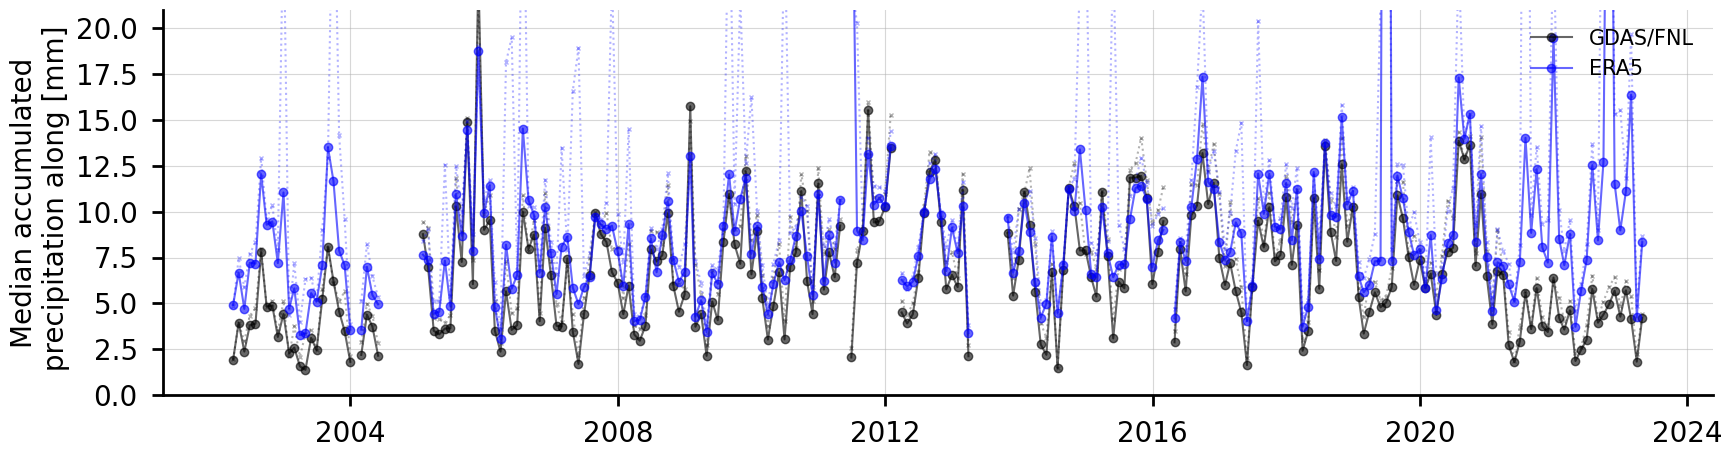

In [40]:
fig, ax = plt.subplots(figsize=(20,5))

quick_month_plot(df_RAINFALL, label='GDAS/FNL', 
                 color='k', mfc='green', mec='k', 
                 ecolor='black', linecolour='k', ax=ax)
quick_month_plot(df_ERA5, label='ERA5', 
                 color='b', mfc='b', mec='b', 
                 ecolor='b', linecolour='b', ax=ax)
plt.ylim(0,21)
plt.show()

In [86]:
HYplot.save_plot(fig, savepath_plot, name='FigureS5')

['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\plots']
make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\FigureS5.jpeg
